1. What the final output should look like?
    - dd
2. Quantities to calculate
    - lambda & sigma (at various apertures)
    - Mgas
    - L vectors of gas/DM/star (in Msun * km/s * kpc unit)
    - Vmax
    - B/T (using various definitions)
    - SFR
    - color, metallicity
3. Quantities that can be derived lateron
    - subhalo mass
    - local (galaxy number) density
    - merger orbit

In [4]:
def mk_gal(gal,
            save=False, verbose=False,
            mstar_min=1e9,
            den_lim=1e6, den_lim2=5e6,
            rmin = -1, Rgal_to_reff=5.0, method_com=1, follow_bp=None,
            unit_conversion="code"):
    """
        Refine given catalog (star, DM, gas) to define a realistic galaxy.
        Raw star/DM/gas catalog as give are only rough representation of a galaxy.
        But not much have to be thrown away, either.

        Returns True if a "good" galaxy is made.


        Parameters
        ----------

        Rgal_to_reff:
            Galaxy radius = Reff * Rgal_to_reff.
            By default, Rgal = 5*Reff.
            (E's have smaller R_t_r, L's have larger.)

        Notes
        -----
        1. Since now (as of 2016.03) galaxy calculation is based on the GalaxyMaker results,
        let's just believe and minimize redundant processes such as determining the center of mass,
        system velocity, and checking the presence of (unwanted) substructure.

        2. Assuming all catalog in the code units.

        3. dr, bin size in determining the radial profile cut scales with exponential factor.
        Without scaling, 0.5kpc bin size is too large for ~1kpc galaxies at high-z.

    """
    # Need halo information
    assert (gal.gcat is not None), ("Need a catalog,"
    "use Galaxy.set_halo() and provide x,y,z,vx,vy,vz,r,rvir, at least"
    "Units are.. ?? ")

    # And at least one component.
    star = gal.star
    if star is not None:
        gal.star["x"] = (gal.star["x"] - gal.gcat["x"])*1e3
        gal.star["y"] = (gal.star["y"] - gal.gcat["y"])*1e3
        gal.star["z"] = (gal.star["z"] - gal.gcat["z"])*1e3
        gal.star["m"] *= 1e11#gal.info.msun
    dm = gal.dm
    if dm is not None:
        gal.dm["x"] = (gal.dm["x"] - gal.gcat["x"])*1e3
        gal.dm["y"] = (gal.dm["y"] - gal.gcat["y"])*1e3
        gal.dm["z"] = (gal.dm["z"] - gal.gcat["z"])*1e3
        gal.dm["m"] *= gal.info.msun
    cell = gal.cell

    assert (gal._has_star or gal._has_dm or gal._has_cell), ("At least"
    "one of three(star, dm, gas) component is needed")

    # all tests passed.
    if verbose:
        print("Making a galaxy:", gal.meta.id)
        print("SAVE:", save)
        print("Halo size:", gal.gcat['rvir'])

    #
    member="Reff"

    # galaxy center from GalaxyMaker. - good enough.
    xc = gal.gcat['x']
    yc = gal.gcat['y']
    zc = gal.gcat['z']

    if verbose: print("xc, yc, zc =", xc, yc, zc)

    rgal_tmp = min([gal.gcat['r'] * 1e3, 30]) # gcat["rvir"] in kpc
    if verbose: print("Rgal_tmp", rgal_tmp)
    print("gal.debug",gal.debug)
    dense_enough = radial_profile_cut(gal, star['x'], star['y'], star['m'],
                         star['vx'], star['vy'], star['vz'],
                         den_lim=den_lim, den_lim2=den_lim2,
                         mag_lim=25,
                         nbins=int(rgal_tmp/0.5),
                         dr=0.5 * gal.info.aexp,
                         rmax=rgal_tmp,
                         debug=gal.debug)

    if not dense_enough:
        print("Not dense enough")
        return False
    ind = np.where((np.square(star['x']) +
                    np.square(star['y']) +
                    np.square(star['z'])) < gal.meta.rgal**2)[0]# in kpc unit

    gal.star = star[ind]

    if gal.debug:
        print('[galaxy.Galaxy.mk_gal] mima vx 1', min(gal.star['vx']), max(gal.star['vx']))


    gal.meta.nstar = len(ind)
    gal.meta.mstar = sum(gal.star['m'])

    if gal.meta.mstar < mstar_min:
        print("Not enough stars: {:.2e} Msun".format(gal.meta.mstar))
        print("{} Aborting... \n".format(len(gal.star['m'])))
        gal.meta.star = False
        return False

    gal.meta.Rgal_to_reff = gal.meta.rgal / gal.meta.reff
    # should not surpass rr_tmp, over where another galaxy might be.

    # Test if the outer annulus has significant amount of stars
    # -> it shouldn't.
#        if verbose: print("Reff: ", reff_tmp)

    # extract galaxy (particles and gas)
    if star is not None:
        nstar_tot = len(star['x'][ind])
        if verbose: print("nstar tot:", nstar_tot)
        if verbose: print("Store stellar particle")

        if 'time' in gal.star.dtype.names and unit_conversion == "code":
            import utils.cosmology
            gal.star['time'] = utils.cosmology.time2gyr(gal.star['time'],
                                         z_now = gal.info.zred,
                                         info=gal.info)

    # VERY arbitrary..
#        gal.Rgal_to_reff = 4 #rgal_tmp / reff_tmp
    rgal_tmp = gal.meta.Rgal_to_reff *gal.meta.reff

    #print(".........", gal.star['m'][100:120], gal.mstar)
    import utils.sampling as smp
    gal.region = smp.set_region(xc=gal.meta.xc, yc=gal.meta.yc, zc=gal.meta.zc, radius = gal.meta.rgal)

    # Now, get cov
#        gal.get_cov(center_only=True)
    #if gal.star is not None:
        #gal._convert_unit_meta(unit_conversion)
        #gal._convert_unit("star", unit_conversion)

    if gal.debug:
        print('[galaxy.Galaxy.mk_gal] meta.v[x,y,z]c', gal.meta.vxc, gal.meta.vyc, gal.meta.vzc)
        print('[galaxy.Galaxy.mk_gal] mima vx 2', min(gal.star['vx']), max(gal.star['vx']))

    if dm is not None:
        if member == "Reff":
            idm = np.where( np.square(dm["x"] - gal.meta.xc) +
                            np.square(dm["y"] - gal.meta.yc) +
                            np.square(dm["z"] - gal.meta.zc) <= np.square(rgal_tmp))[0]
        elif member == "v200":
        # Although the velocity is redefined later,
        # particle membership is fixed at this point.
            idm = np.where( np.square(dm["vx"] - gal.meta.vxc / gal.info.kms)+
                            np.square(dm["vy"] - gal.meta.vyc / gal.info.kms)+
                            np.square(dm["vz"] - gal.meta.vzc / gal.info.kms) <= np.square(200**2))[0]
        gal._convert_unit("dm", unit_conversion)

    if cell is not None:
        if verbose: print("Cell is NOT none")
        icell = np.where(np.square(cell["x"] - xc) +
                         np.square(cell["y"] - yc) +
                         np.square(cell["z"] - zc) <= np.square(rgal_tmp))[0]

        gal._add_cell(cell, icell)
        gal._convert_unit("cell", unit_conversion)
        gal.cal_mgas()

        gal.cell = np.recarray(ncell_tot, dtype=dtype_cell)
        gal.cell['x'] = (cell['x'][icell] - xc) * gal.info.pboxsize * 1000
        gal.cell['y'] = (cell['y'][icell] - yc) * gal.info.pboxsize * 1000
        gal.cell['z'] = (cell['z'][icell] - zc) * gal.info.pboxsize * 1000
        gal.cell['dx'] = cell['dx'][icell] * gal.info.pboxsize * 1000
        gal.cell['rho'] = cell['var0'][icell]
        gal.cell['vx'] = cell['var1'][icell] * gal.info.kms - gal.meta.vxc
        gal.cell['vy'] = cell['var2'][icell] * gal.info.kms - gal.meta.vyc
        gal.cell['vz'] = cell['var3'][icell] * gal.info.kms - gal.meta.vzc
        gal.cell['temp'] = cell['var4'][icell]
        gal.cell['metal'] = cell['var5'][icell]


    # Some more sophistications.
    """
    print("Rgal = 4 * Reff = ", rgal_tmp * gal.info.pboxsize * 1000)

        # Save sink particle as a BH, not cloud particles.

    """
    return True


def radial_profile_cut(gal, xx, yy, mm, vx, vy, vz,
                       den_lim=1e6, den_lim2=5e6,
                       mag_lim=25, nbins=100, rmax=20, dr=0.5,
                       debug=False):
    # 2D photometry. (if rotated towards +y, then use x and z)
    # now assuming +z alignment.
    rr = np.sqrt(np.square(xx) + np.square(yy))# in kpc unit
    if debug:
        print("min(rr) {}\n max(rr){}\n min(xx){}\n max(xx){}".format(
                               min(rr), max(rr), min(xx), max(xx)))

    # Account for weights.
    i_sort = np.argsort(rr)
    r_sorted = rr[i_sort]
    m_sorted = mm[i_sort]

    rmax = min([np.max(rr), rmax])
    nbins = int(rmax/dr)

    if nbins < 3:
        print("Too small size \n # of stars:", len(rr))
        return False

    frequency, bins = np.histogram(r_sorted, bins = nbins, range=[0, rmax])
    bin_centers = bins[:-1] + 0.5 * dr # remove the rightmost boundary.

    m_radial = np.zeros(nbins)
    ibins = np.concatenate((np.zeros(1,dtype=int), np.cumsum(frequency)))

    i_r_cut1 = nbins -1 # Maximum value
    # on rare occasions, a galaxy's stellar surface density
    # never crosses the density limit. Then i_r_cut1 = last index.
    for i in range(nbins):
        m_radial[i] = np.sum(m_sorted[ibins[i]:ibins[i+1]])
        # Check stellar surface density
        sig_at_r = m_radial[i]/(2 * np.pi * bin_centers[i] * dr)
        if debug:
            print(sig_at_r, den_lim)
        if sig_at_r < den_lim:
            i_r_cut1 = i-1
            break
    #i_r_cut2= np.argmax(m_radial/(2 * np.pi * bin_centers * dr) < den_lim2)
    # If for some reason central region is less dense,
    # profile can end at the first index.
    # Instead coming from backward, search for the point the opposite condition satisfied.
    if debug:
        print(rmax, nbins)
        print("frequency", frequency)
        print("bins", bins)
        print("ibins", ibins)
        print("bin centers", bin_centers)
        print("m_radial", m_radial)

    den_radial_inverse = m_radial[::-1]/(2 * np.pi * bin_centers[::-1] * dr)
    if debug: print("den_radial_inverse", den_radial_inverse)
    if max(den_radial_inverse) < 2 * den_lim2:
        np.set_printoptions(precision=3)
        print("radial density :",den_radial_inverse)
        return False
    i_r_cut2=len(m_radial) - np.argmax(den_radial_inverse > den_lim2) -1
    if debug:
        print("[galaxy.Galaxy.radial_profile_cut] m_radial \n", m_radial)
        print("[galaxy.Galaxy.radial_profile_cut] den_radial_inverse \n", den_radial_inverse)
        print("[galaxy.Galaxy.radial_profile_cut] i_r_cut2", i_r_cut2)

    mtot2 = sum(m_radial[:i_r_cut2])
    mtot1 = sum(m_radial[:i_r_cut1])
    i_reff2 = np.argmax(np.cumsum(m_sorted) > (0.5*mtot2))
    i_reff1 = np.argmax(np.cumsum(m_sorted) > (0.5*mtot1))
    gal.meta.reff2 = r_sorted[i_reff2]
    gal.meta.reff  = r_sorted[i_reff1]
    #print(bin_centers, i_r_cut2, m_radial)
    gal.meta.rgal2 = max([bin_centers[i_r_cut2],4*gal.meta.reff2])
    gal.meta.rgal  = max([bin_centers[i_r_cut1],4*gal.meta.reff])#bin_centers[i_r_cut1]

#       velocity center
#       It is not wrong for BCGs to have very large Reff(~50kpc).
#       But referring the average velocity of stellar particles inside 50kpc
#       as the system velocity is WRONG.
#       If 1Reff is huge, try smaller aperture when measuring the system velocity.
#
    if debug:
        print("[galaxy.Galaxy.radial_profile_cut] mtot, mtot2", mtot1, mtot2)

    i_close = i_sort[:np.argmax(np.cumsum(m_sorted) > (0.2*mtot2))] # 20% closest particles


    gal.meta.vxc = np.average(vx[i_close])
    gal.meta.vyc = np.average(vy[i_close])
    gal.meta.vzc = np.average(vz[i_close])

    return True

In [5]:
import numpy as np
import collections
from galaxymodule import galaxy
import pickle
import load
from load.hydro import Hydro

from analysis.cal_lambda import *

##
##
## "from galaxymodule.galaxy import Galaxy " in load.rd_GM fails at first try,
# but successes at second try. 

## parameters

In [6]:
nout=782
Mcut = 1e10

In [7]:
cal_lambda_params = dict(npix_per_reff=5,
                        rscale=3.0,
                        method='ellip',
                        n_pseudo=1,
                        verbose=False,
                        voronoi=None,#voronoi_dict,
                        mge_interpol = True)
mk_gal_params = dict()

In [8]:
# Load data
import tree


s = load.sim.Sim(nout=nout)
gcat = tree.halomodule.Halo(nout=nout, is_gal=True)
# Check for tree file before reading.
# Or, the fortran routine crashes causing the kernel crash without any error message. 

[sim._hilbert_cpulist] No AMR instance,
[sim._hilbert_cpulist] Loading one...
An AMR instance is created
 Sim
An AMR instance is created
 Sim
Simulation set up.
[Halo.load_info] loading info
[Halo.load_info] nout = 782, base =./


## Sampling

Mass cut log(M) > 10

In [7]:
i_massive = np.where((gcat.data["id"] % 10 == 5) * (gcat.data["m"] > Mcut))[0]
print("there are {} galaxies in the sample.".format(len(i_massive)))
large_gals = gcat.data[i_massive]

gg = load.rd_GM.Gal(782, catalog=large_gals[3], info=s.info)
# No chance for a halo to come in.

there are 2769 galaxies in the sample.
info <load.info.Info object at 0x7f60a746ec18>
File Not Found: ./halo/HAL_00782/hal_dms_0000035
No DM data loaded
File Not Found: ./GalaxyMaker/CELL_00782/gal_cells_0000035
No CELL data loaded


In [20]:
large_gals[3]["mvir"]

1.5414468e+12

In [21]:
gg = None

In [8]:
from galaxymodule import mk_gal_params as mgp

mgp.HAGN["verbose"] = False
gg.debug=False
#gg.mk_gal(**mgp.HAGN)
mk_gal(gg,**mgp.HAGN)

gal.debug False


True

In [15]:
img_hist = gg.cal_b2t(hist=True)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Stars are ready! 

    def cal_b2t(gal, ptype='star', disk_criterion="Abadi2003",
                bound_only = True, hist=False, proj="z"):
        """
        Measure bulge to total ratio of the galaxy.

        parameters
        ----------
        ptype : str
            type of particle to consider.
        disk_criterion : str
            discrimination criterion. (Defaults to "Abadi2003")
        bound_only : logical
            consider bound particles only
        hist : logical
            if True, ellipticity histogram is returned
        """
        def gas_mass(cell, info):
            """
                return mass of gas cells.
                Keep in mind that size of cells differ.
            """
            msun = 1.98892e33 # solar mass in gram.
            return (cell['rho'] * info.unit_d) * (cell['dx'] * info.unit_l)**3 / msun

        import numpy as np

        if proj=="x":
            pos1, pos2, vel1, vel2 = 'y', 'z', 'vy', 'vz'
        if proj=="y":
            pos1, pos2, vel1, vel2 = 'z', 'x', 'vz', 'vx'
        if proj=="z":
            pos1, pos2, vel1, vel2 = 'x', 'y', 'vx', 'vy'



        # Radius

        # Calculating boundness requires total mass inside a radius.
        # -> DM, Cell are also needed.
        #part = getattr(gal, ptype)

        m_d = gal.dm['m']# * info.msun

        if hasattr(gal, "cell"):
            m_g = gas_mass(gal.cell, gal.info)
            m_all = np.concatenate((gal.star['m'], m_g, m_d))
        else:
            m_all = np.concatenate((gal.star['m'], m_d))


        r_s = np.sqrt(np.square(gal.star['x'])
                    + np.square(gal.star['y'])
                    + np.square(gal.star['z']))

        if hasattr(gal, "cell"):
            r_g = np.sqrt(np.square(gal.cell['x'])
                    + np.square(gal.cell['y'])
                    + np.square(gal.cell['z']))
        r_d = np.sqrt(np.square(gal.dm['x'])
                    + np.square(gal.dm['y'])
                    + np.square(gal.dm['z']))

        if hasattr(gal, "cell"):
            r_all = np.concatenate((r_s, r_g, r_d))
        else:
            r_all = np.concatenate((r_s, r_d))
        i_sorted = np.argsort(r_all)
        m_enc = np.cumsum(m_all[i_sorted])

        # First nstar indices are stars.
        if bound_only:
            i_star = i_sorted[gal.bound_ptcl]
            x = gal.star[pos1][gal.bound_ptcl]
            y = gal.star[pos2][gal.bound_ptcl]
            vx = gal.star[vel1][gal.bound_ptcl]
            vy = gal.star[vel2][gal.bound_ptcl]
            m = gal.star['m'][gal.bound_ptcl]# * info.msun
        else:
            i_star = i_sorted[0:len(r_s)]
            x = gal.star[pos1]
            y = gal.star[pos2]
            vx = gal.star[vel1]
            vy = gal.star[vel2]
            m = gal.star['m']# * info.msun

        #boxtokpc = gal.info.pboxsize * 1000
        G = 6.67384e-11  # m^3 kg^-1 s^-2
        kpc_to_m = 3.08567758e19
        msun_in_kg = 1.9891e30 # kg
        v_circ = np.sqrt(G * msun_in_kg * m_enc[i_star]/
                        (kpc_to_m * r_all[i_star])) * 1e-3 # m/s to in km/s

        j_circ = np.sqrt(np.square(x)
                    + np.square(y)) * v_circ # * boxtokpc omitted (later compensated.)
        # Finally, r in code unit, v in km/s
        j_phi = (x * vy - y * vx) # * boxtokpc omitted.
        ellipticity = j_phi / j_circ

        if disk_criterion == "Scannapieco2009":
            # < 0.8 from Scannapieco 2009
            disk = np.sum(m[ellipticity < 0.8])
        elif disk_criterion == "Abadi2003":
            #bulge = 2.0 * np.sum(gal.star['m'][j_phi < 0])
            bulge = 2.0 * min([np.sum(m[j_phi < 0]),
                               np.sum(m[j_phi > 0])])
            disk = np.sum(m) - bulge

        gal.meta.d2t = disk / gal.meta.mstar # or sum(gal.star['m'][ind])
        if hist:
            return np.histogram(ellipticity, range=[-2,2], bins=20)

In [13]:
min(gg.star["m"])

3320397.0815520734

In [11]:
import matplotlib.pyplot as plt

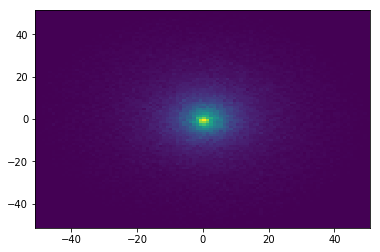

In [12]:
plt.hist2d(gg.star["x"], gg.star["y"], bins=100)
plt.show()